## Data import

please see Preprocessing > PreprocessingMain.ipynb for more information regarding data import

In [1]:
import pandas as pd

# load in Clean Gene and TE transcriptomic expression
Gene = pd.read_csv('~/Desktop/UROMOL-TE/Clean-UROMOL-GENE.csv', index_col='Unnamed: 0')
TE = pd.read_csv('~/Desktop/UROMOL-TE/Clean-UROMOL-TE.csv', index_col='Unnamed: 0')

TransposableClasses = ['LINE', 'SINE', 'LTR', 'DNA', 'Retroposon']
RepName = pd.read_csv('~/Desktop/UROMOL-TE/TE-RepName.csv', index_col= 'Unnamed: 0', usecols=[0, 3])
TENames = RepName[RepName['repClass'].isin(TransposableClasses)].index.values.tolist()
TE = TE.loc[TENames, :]

## Sum TE expression

in order to preform Gsea analysis on TE expression, we need to sum TE expression by class. There are 5 classes: LINE,
SINE, LTR, DNA, Retroposon

In [16]:
# load in class information and merge with TE dataframe
TEclass = pd.concat([TE, RepName], axis=1)

# Isolate TE expression by class and drop 'repClass' column
LINE = TEclass[TEclass['repClass'] == 'LINE'].drop('repClass', axis='columns')
SINE = TEclass[TEclass['repClass'] == 'SINE'].drop('repClass', axis='columns')
LTR = TEclass[TEclass['repClass'] == 'LTR'].drop('repClass', axis='columns')
DNA = TEclass[TEclass['repClass'] == 'DNA'].drop('repClass', axis='columns')
Retroposon = TEclass[TEclass['repClass'] == 'Retroposon'].drop('repClass', axis='columns')

# Sum TE expression (isolated by class) for each patient to generate a 1D vector of expression for each TE class
LINE = LINE.sum(axis='rows')
SINE = SINE.sum(axis='rows')
LTR = LTR.sum(axis='rows')
DNA = DNA.sum(axis='rows')
Retroposon = Retroposon.sum(axis='rows')

## TE sum Correlations

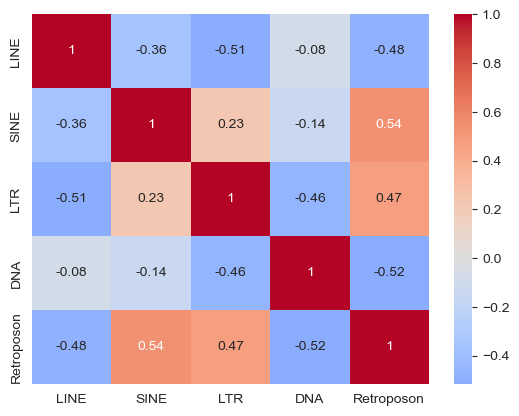

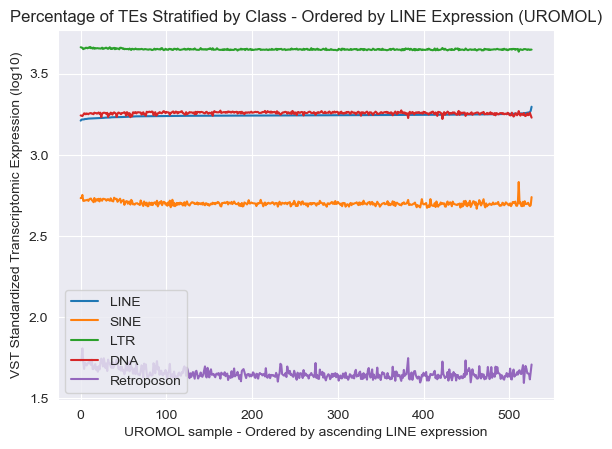

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
from EnrichmentAnalysis.Funcs.PlotTEClassExpression import plotClassExp

df = pd.concat([LINE, SINE, LTR, DNA, Retroposon], axis=1)
df.columns = ['LINE','SINE', 'LTR', 'DNA', 'Retroposon']

sns.heatmap(df.corr(), center=0, cmap="coolwarm", annot=True)
plt.show()

plotClassExp(df, 'UROMOL')

In [3]:
from scipy.stats import pearsonr
from tqdm import tqdm

titleCol = ['Gene',
            'LINE-corr', 'LINE-pval',
            'SINE-corr', 'SINE-pval',
            'LTR-corr', 'LTR-pval',
            'DNA-corr', 'DNA-pval',
            'RETRO-corr', 'RETRO-pval']

Correlation = []

for gene in tqdm(Gene.index.values.tolist()):
    geneComparitor = Gene.loc[gene, :]
    LINEcorr, LINEpval = pearsonr(geneComparitor, LINE)
    SINEcorr, SINEpval = pearsonr(geneComparitor, SINE)
    LTRcorr, LTRpval = pearsonr(geneComparitor, LTR)
    DNAcorr, DNApval = pearsonr(geneComparitor, DNA)
    Retrocorr, Retropval = pearsonr(geneComparitor, Retroposon)

    out = [gene,
           LINEcorr, LINEpval,
           SINEcorr, SINEpval,
           LTRcorr, LTRpval,
           DNAcorr, DNApval,
           Retrocorr, Retropval]

    Correlation.append(out)

Corrdf = pd.DataFrame(Correlation, columns=titleCol)
Corrdf.set_index('Gene', inplace=True)

 30%|██▉       | 17181/57374 [00:04<00:09, 4422.17it/s]/Users/andrewgarven/.conda/envs/TransposableElements/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 57374/57374 [00:13<00:00, 4276.80it/s]


In [4]:
import pyensembl
# load gene names from GRCh38
data = pyensembl.EnsemblRelease(77)

# remove 2 ensembl IDs that do not have a gene name (therefore cannot be used for gsea analysis)
rename = {}

for i, item in enumerate(Corrdf.index.values.tolist()):
    try:
        if ',' in item:
            newitem = item.split(',')[0]
            gene = data.gene_by_id(gene_id=newitem).gene_name
            rename[item] = gene
        else:
            gene = data.gene_by_id(gene_id=item).gene_name
            rename[item] = gene
    except:
        pass

Corrdf = Corrdf.rename(index=rename)

In [8]:
def GeneratePreRank(df, ElementType):

    # this function evalautes the output of pearsonr analysis and ranks the geneset for gsea analysis

    df = df.loc[: ,[f'{ElementType}-corr', f'{ElementType}-pval']]
    df = df[df[f'{ElementType}-pval'] < 0.05].drop(f'{ElementType}-pval', axis=1)
    df = df.sort_values(f'{ElementType}-corr', ascending=False)
    return df

linecorr = GeneratePreRank(Corrdf, 'LINE')
sinecorr = GeneratePreRank(Corrdf, 'SINE')
ltrcorr = GeneratePreRank(Corrdf, 'LTR')
dnacorr = GeneratePreRank(Corrdf, 'DNA')
retrocorr = GeneratePreRank(Corrdf, 'RETRO')



ValueError: x and y must have the same length.

In [41]:
import gseapy as gp

pre_res = gp.prerank(rnk=ltrcorr, # or rnk = rnk,
                     gene_sets='GO_Biological_Process_2021',
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

2022-12-07 12:46:49,122 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2022-12-07 12:46:49,179 Parsing data files for GSEA.............................
INFO:gseapy:Parsing data files for GSEA.............................
2022-12-07 12:46:49,182 Enrichr library gene sets already downloaded in: /Users/andrewgarven/.cache/gseapy, use local file
INFO:gseapy:Enrichr library gene sets already downloaded in: /Users/andrewgarven/.cache/gseapy, use local file
2022-12-07 12:46:49,326 0996 gene_sets have been filtered out when max_size=1000 and min_size=5
INFO:gseapy:0996 gene_sets have been filtered out when max_size=1000 and min_size=5
2022-12-07 12:46:49,329 5040 gene_sets used for further statistical testing.....
INFO:gseapy:5040 gene_sets used for further statistical testing.....
2022-12-07 12:46:49,331 Start to run GSEA...Might take a while..................
INFO:gseapy:Start to run GSEA...Might take a while..................
2022-12-07 12:51:02,

In [45]:
pre_res.res2d.to_csv('LTR-gsea-BiologicalProcess2021.csv')

TypeError: 'Figure' object is not callable

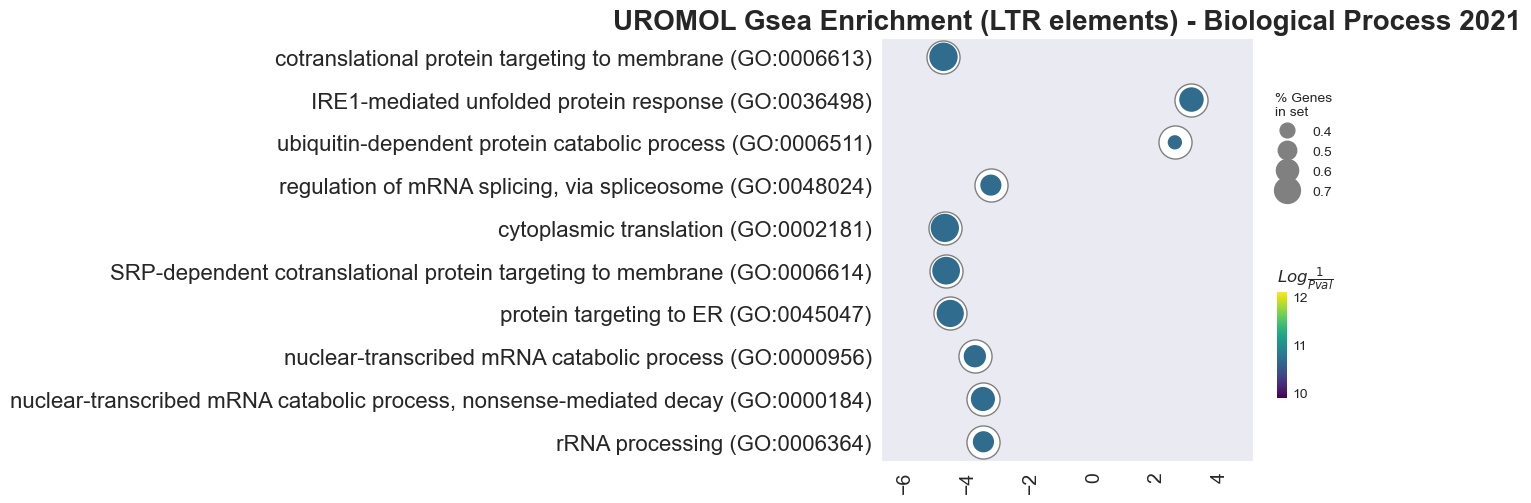

In [64]:
from gseapy import ringplot
import matplotlib.pyplot as plt

ax = ringplot(pre_res.res2d,
             column="FDR q-val",
             title='UROMOL Gsea Enrichment (LTR elements) - Biological Process 2021',
             cmap=plt.cm.viridis,
             size=10,
             cutoff=0.25,
             show_ring=True)

fig = ax.figure()
print(type(fig))

#fig.savefig("LTR-ringplot.png")